##  1단계 - 캐릭터 포즈 데이터 증강 및 분류 모델(MobileNet) 학습 및 평가

### 1. 데이터 증강 및 데이터셋 생성
가지고있는 10개 아바타 포즈 별 png 파일이 추후 yolo v8의 객체(아바타)의 포즈 인지 기능을 구현하는데 부족해 데이터 증강을 수행했다.raw/poses_10에 있는 아바타의 10개 포즈 png 파일을 읽어서 랜덤 색상의 배경이나 노이즈 및 변형을 가해 classifier_dataset 폴더에 클래스별로 저장하는 코드다. 


In [14]:
import os
import shutil
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

# 경로 설정
base_path = os.path.expanduser("~/maple-vision-search/data")
src_path = os.path.join(base_path, 'raw/poses_10')
dst_path = os.path.join(base_path, 'labeled') # 학습 코드와 일치시킴

def generate_augmented_image(img_path, output_path):
    """
    원본 PNG(투명 배경)를 읽어 랜덤 배경색을 채우고 증강하여 저장
    """
    img = Image.open(img_path).convert("RGBA")
    
    # 1. 랜덤 배경 생성 (RGB)
    bg_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    background = Image.new("RGB", img.size, bg_color)
    
    # 2. 합성 (투명 배경 아바타를 랜덤 배경 위에 얹음)
    background.paste(img, (0, 0), img)
    
    # 3. 추가 증강: 가우시안 블러 또는 노이즈 (선택적)
    if random.random() > 0.8:
        background = background.filter(ImageFilter.GaussianBlur(radius=random.uniform(0, 1.0)))
        
    # 4. 결과 저장 (JPG)
    background.save(output_path, "JPEG")

def create_dataset(num_samples_per_class=500):
    splits = ['train', 'val', 'test']
    ratios = [0.8, 0.1, 0.1] # $8:1:1$ 비율
    
    if not os.path.exists(src_path):
        print(f"Error: {src_path} 경로가 존재하지 않습니다.")
        return

    # 클래스(포즈) 목록 추출
    pose_files = [f for f in os.listdir(src_path) if f.endswith('.png')]
    
    for pose_file in pose_files:
        class_name = pose_file.replace('avatar_', '').replace('.png', '')
        print(f"Processing class: {class_name}...")
        
        # 폴더 생성
        for split in splits:
            os.makedirs(os.path.join(dst_path, split, class_name), exist_ok=True)
        
        # 각 클래스당 목표 샘플 수만큼 증강 이미지 생성
        for i in range(num_samples_per_class):
            # 분할 결정
            r = random.random()
            if r < ratios[0]:
                split = 'train'
            elif r < ratios[0] + ratios[1]:
                split = 'val'
            else:
                split = 'test'
            
            save_name = f"{class_name}_{i:04d}.jpg"
            save_path = os.path.join(dst_path, split, class_name, save_name)
            
            # 증강 및 저장 실행
            generate_augmented_image(os.path.join(src_path, pose_file), save_path)

if __name__ == "__main__":
    # 기존 데이터 삭제 (필요 시)
    if os.path.exists(dst_path):
        shutil.rmtree(dst_path)
    
    create_dataset(num_samples_per_class=500)
    print("Dataset generation completed.")

Processing class: stand1...
Processing class: stabO1...
Processing class: stand2...
Processing class: prone...
Processing class: walk2...
Processing class: shoot1...
Processing class: fly...
Processing class: jump...
Processing class: swingO1...
Processing class: walk1...
Dataset generation completed.


## 2. 분류 모델(MobileNetV3-Small) 학습
1번 과정에서 증강한 데이터를 MobileNet 모델에 넣어서, 합성 이미지(MapleStoryDetectionSampleGenerator로 랜덤 배경 노이즈가 섞인 500여장의 이미지) 속의 아바타의 포즈를 분류할 수 있는, 즉 포즈 클래스값을 라벨링할 수 있는 분류 모델을 학습시켰다. 학습 중간에 Train Loss와 Val Loss, Val Acc를 확인할 수 있는 코드를 추가했다. 

11.4%

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/ssy/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100.0%


Epoch [1/15]
Train $Loss$: 0.0731 | Val $Loss$: 0.0003
Train $Acc$: 98.32% | Val $Acc$: 100.00%
--- Best Model Saved ---
------------------------------
Epoch [2/15]
Train $Loss$: 0.0001 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [3/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [4/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [5/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [6/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [7/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Val $Acc$: 100.00%
------------------------------
Epoch [8/15]
Train $Loss$: 0.0000 | Val $Loss$: 0.0000
Train $Acc$: 100.00% | Va

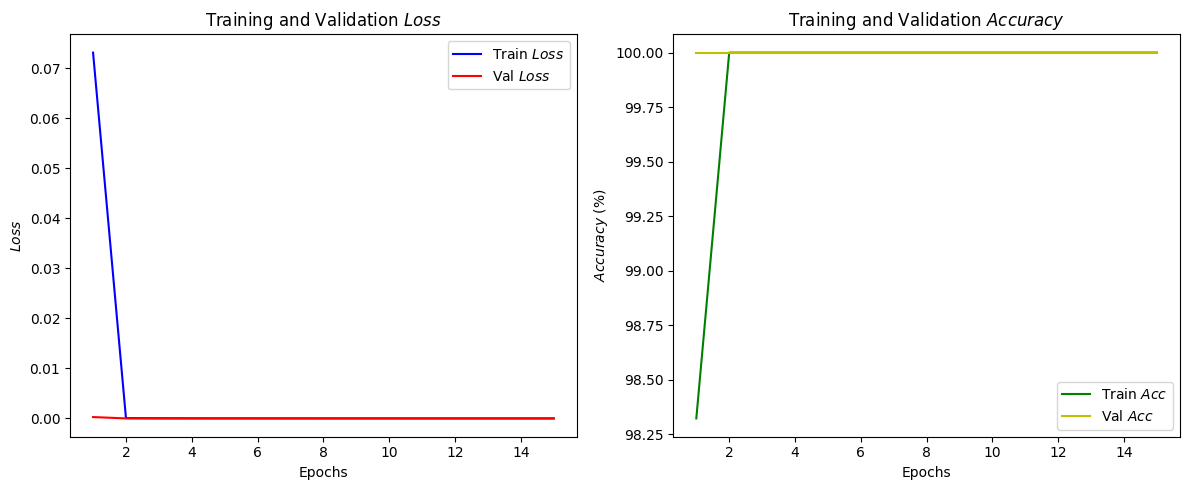

In [ ]:
import os
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 환경 및 하이퍼파라미터 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001
base_path = os.path.expanduser("~/maple-vision-search/data") 

# 2. 데이터 전처리 및 로더 설정
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# base_path 수정: 'labeled' 경로를 명시적으로 포함
labeled_path = os.path.join(base_path, 'labeled')

train_dataset = datasets.ImageFolder(os.path.join(labeled_path, 'train'), transform=data_transforms)
val_dataset = datasets.ImageFolder(os.path.join(labeled_path, 'val'), transform=data_transforms)

# 테스트 셋 미리 로드
test_path = os.path.join(labeled_path, 'test')
if os.path.exists(test_path):
    test_dataset = datasets.ImageFolder(test_path, transform=data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. 모델 정의 (MobileNetV3 Small)
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, 10) # 10개 포즈 클래스
model = model.to(DEVICE)

# 4. 손실함수 및 최적화 도구
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 학습 곡선 시각화 함수 정의
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train $Loss$')
    plt.plot(epochs, val_losses, 'r-', label='Val $Loss$')
    plt.title('Training and Validation $Loss$')
    plt.xlabel('Epochs')
    plt.ylabel('$Loss$')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'g-', label='Train $Acc$')
    plt.plot(epochs, val_accs, 'y-', label='Val $Acc$')
    plt.title('Training and Validation $Accuracy$')
    plt.xlabel('Epochs')
    plt.ylabel('$Accuracy$ (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 학습 루프 시작 전 리스트 초기화(학습 곡선 시각화용)
train_losses, val_losses = [], []
train_accs, val_accs = [], []

def train_and_validate():
    best_acc = 0.0
    
    for epoch in range(EPOCHS):
        # 1. 학습 단계
        model.train()
        train_loss = 0.0
        train_correct = 0  # --- 추가된 부분 ---
        train_total = 0    # --- 추가된 부분 ---
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # --- train_acc 계산 로직 추가 ---
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            # -------------------------------

        # 2. 검증 단계
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # 3. 에폭별 지표 계산
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total # --- 수정된 변수 사용 ---
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        print(f"Epoch [{epoch+1}/{EPOCHS}]")
        print(f"Train $Loss$: {epoch_train_loss:.4f} | Val $Loss$: {epoch_val_loss:.4f}")
        print(f"Train $Acc$: {epoch_train_acc:.2f}% | Val $Acc$: {epoch_val_acc:.2f}%")
        
        # 최고 성능 모델 저장
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_pose_classifier.pth")
            print("--- Best Model Saved ---")
        print("-" * 30)

        # 리스트에 지표 추가 (시각화용)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc) # --- 수정된 변수 사용 ---
        val_accs.append(epoch_val_acc)

    # 모든 학습 종료 후 시각화
    plot_learning_curves(train_losses, val_losses, train_accs, val_accs)
    
if __name__ == "__main__":
    train_and_validate()

## 3. 최종 테스트 및 추론 코드
학습시킨 포즈 클래스 분류 모델의 성능을 평가하고 단일 이미지에 대한 예측을 수행했다.

In [18]:
# 1. 테스트 데이터셋 평가 (종합 성적)
def evaluate_test_set():
    test_path = os.path.join(base_path, 'labeled', 'test') 
    test_dataset = datasets.ImageFolder(test_path, transform=data_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model.load_state_dict(torch.load("best_pose_classifier.pth"))
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f"Final Test $Accuracy$: {100 * correct / total:.2f}%")

# 2. 단일 이미지 추론 (실제 사용용)
def predict_pose(image_path):
    class_names = sorted(train_dataset.classes) # 알파벳 순 정렬된 클래스명
    
    # 모델 로드 및 설정
    infer_model = models.mobilenet_v3_small()
    infer_model.classifier[3] = nn.Linear(infer_model.classifier[3].in_features, 10)
    infer_model.load_state_dict(torch.load("best_pose_classifier.pth", map_location=DEVICE))
    infer_model.to(DEVICE).eval()
    
    # 이미지 처리
    from PIL import Image
    img = Image.open(image_path).convert("RGB")
    input_tensor = data_transforms(img).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        output = infer_model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        confidence, pred_idx = torch.max(probabilities, 0)
        
    return class_names[pred_idx], confidence.item()

if __name__ == "__main__":
    # 1. 전체 테스트 셋 검사
    evaluate_test_set()
    
    # 2. 개별 이미지 검사 (경로가 실제 존재해야 함)
    target_img = os.path.expanduser("~/maple-vision-search/data/labeled/test/stand/sample.jpg")
    if os.path.exists(target_img):
        pose, conf = predict_pose(target_img)
        print(f"Pose: {pose}, Confidence: {conf:.4f}") # 예: 0.9854

Final Test $Accuracy$: 100.00%


---

## 4. 테스트 이미지 추론 결과 시각화 함수 정의

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms as T

def visualize_predictions_varied(model, loader, device, class_names, num_images=9):
    """
    다양한 클래스의 이미지를 선택하고, 원본/블러/노이즈 상태에서의 예측 결과를 시각화합니다.
    """
    model.eval()
    
    # 1. 데이터 확보 및 랜덤 샘플링
    # 로더에서 여러 배치를 가져와 다양한 데이터를 확보합니다.
    all_inputs = []
    all_labels = []
    max_batches_to_fetch = 10  # 충분한 데이터 확보를 위해 여러 배치를 순회
    fetched = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            all_inputs.append(inputs)
            all_labels.append(labels)
            fetched += 1
            if fetched >= max_batches_to_fetch:
                break
    
    if not all_inputs:
        print("데이터 로더가 비어있습니다.")
        return

    # 데이터를 하나로 합칩니다.
    inputs_tensor = torch.cat(all_inputs, dim=0)
    labels_tensor = torch.cat(all_labels, dim=0)
    
    total_samples = inputs_tensor.size(0)
    actual_num_images = min(total_samples, num_images)
    
    # 전체 데이터 중에서 무작위로 인덱스를 선택합니다.
    random_indices = random.sample(range(total_samples), actual_num_images)
    
    selected_inputs = inputs_tensor[random_indices].to(device)
    selected_labels = labels_tensor[random_indices].to(device)

    # 2. 블러/노이즈 증강 정의 (텐서용)
    # 가우시안 블러 (torchvision 제공)
    blur_transform = T.GaussianBlur(kernel_size=(5, 5), sigma=(1.5, 2.5))

    # 노이즈 추가 함수 (커스텀)
    def add_noise(tensor_img, noise_factor=0.3):
        noise = torch.randn_like(tensor_img) * noise_factor
        noisy_img = tensor_img + noise
        # 정규화된 범위 내에서 클리핑하는 것이 좋지만, 시각적 효과를 위해 생략하거나 범위를 넓게 잡을 수 있습니다.
        return torch.clamp(noisy_img, -2.5, 2.5) # 대략적인 정규화 범위로 클리핑

    processed_inputs = []
    aug_types = []

    # 3. 선택된 이미지에 원본, 블러, 노이즈 적용
    for i in range(actual_num_images):
        img = selected_inputs[i].clone() # 원본 유지를 위해 복제
        
        # 3개의 그룹으로 나누어 적용 (순서대로 반복)
        remainder = i % 3
        if remainder == 0:
            aug_types.append("Original")
            processed_inputs.append(img)
        elif remainder == 1:
            # 블러는 4D 텐서(배치 포함)를 기대하므로 차원 추가/제거 필요
            blurred = blur_transform(img.unsqueeze(0)).squeeze(0)
            aug_types.append("Blur")
            processed_inputs.append(blurred)
        else:
            noisy = add_noise(img)
            aug_types.append("Noise")
            processed_inputs.append(noisy)
            
    # 리스트를 다시 텐서 배치로 변환
    final_batch = torch.stack(processed_inputs).to(device)

    # 4. 모델 예측 수행
    with torch.no_grad():
        outputs = model(final_batch)
        _, preds = torch.max(outputs, 1)

    # 5. 시각화
    plt.figure(figsize=(15, 5 * ((actual_num_images + 2) // 3)))
    rows = (actual_num_images + 2) // 3

    # 역정규화를 위한 평균과 표준편차 (학습 시 사용한 값과 동일해야 함)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(actual_num_images):
        ax = plt.subplot(rows, 3, i + 1)
        ax.axis('off')
        
        # 이미지 역정규화 (Denormalization)
        img_np = final_batch[i].cpu().numpy().transpose((1, 2, 0))
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        color = 'green' if preds[i] == selected_labels[i] else 'red'
        
        # 제목에 증강 타입 정보 추가
        title_text = f"[{aug_types[i]}]\nPred: {class_names[preds[i]]}\nTrue: {class_names[selected_labels[i]]}"
        ax.set_title(title_text, color=color, fontsize=11)
        plt.imshow(img_np)
        
    plt.tight_layout()
    plt.show()

## 5. 혼동 행렬 생성 함수 정의
어떤 포즈를 다른 포즈로 오인하고 있는지 분석하기 위함이다.

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

---
## 최종 결과 시각화

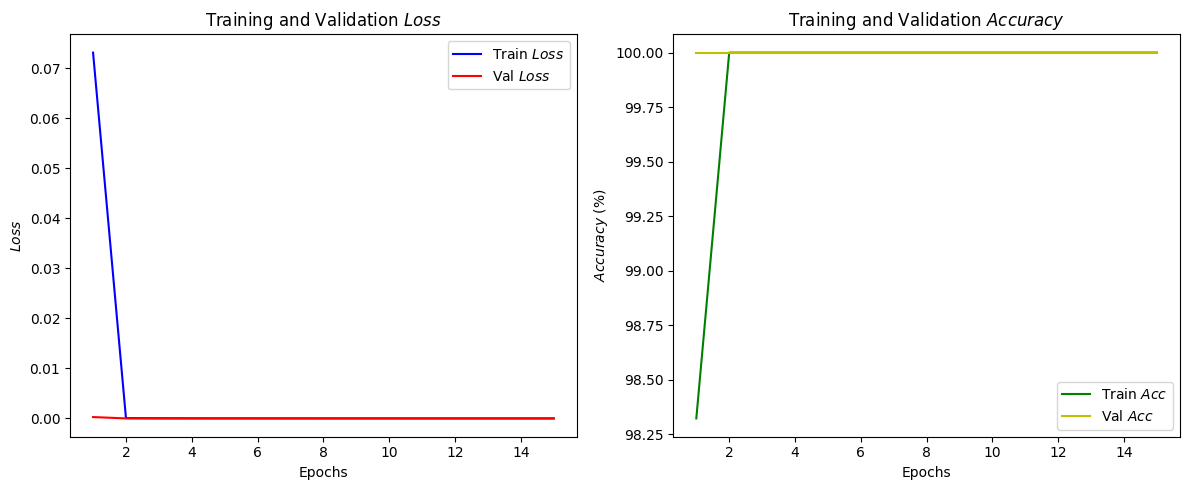

Generating Confusion Matrix...


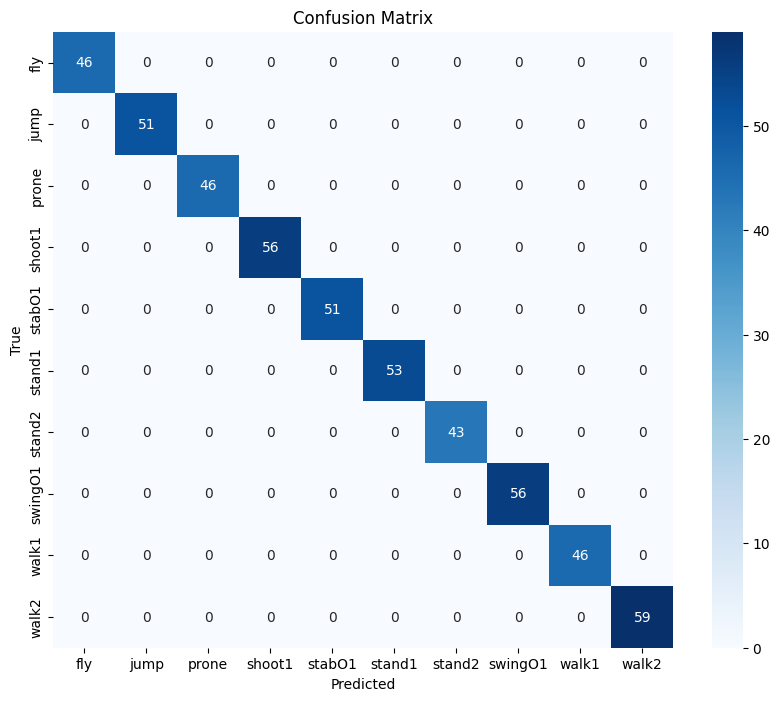

Visualizing Sample Predictions...


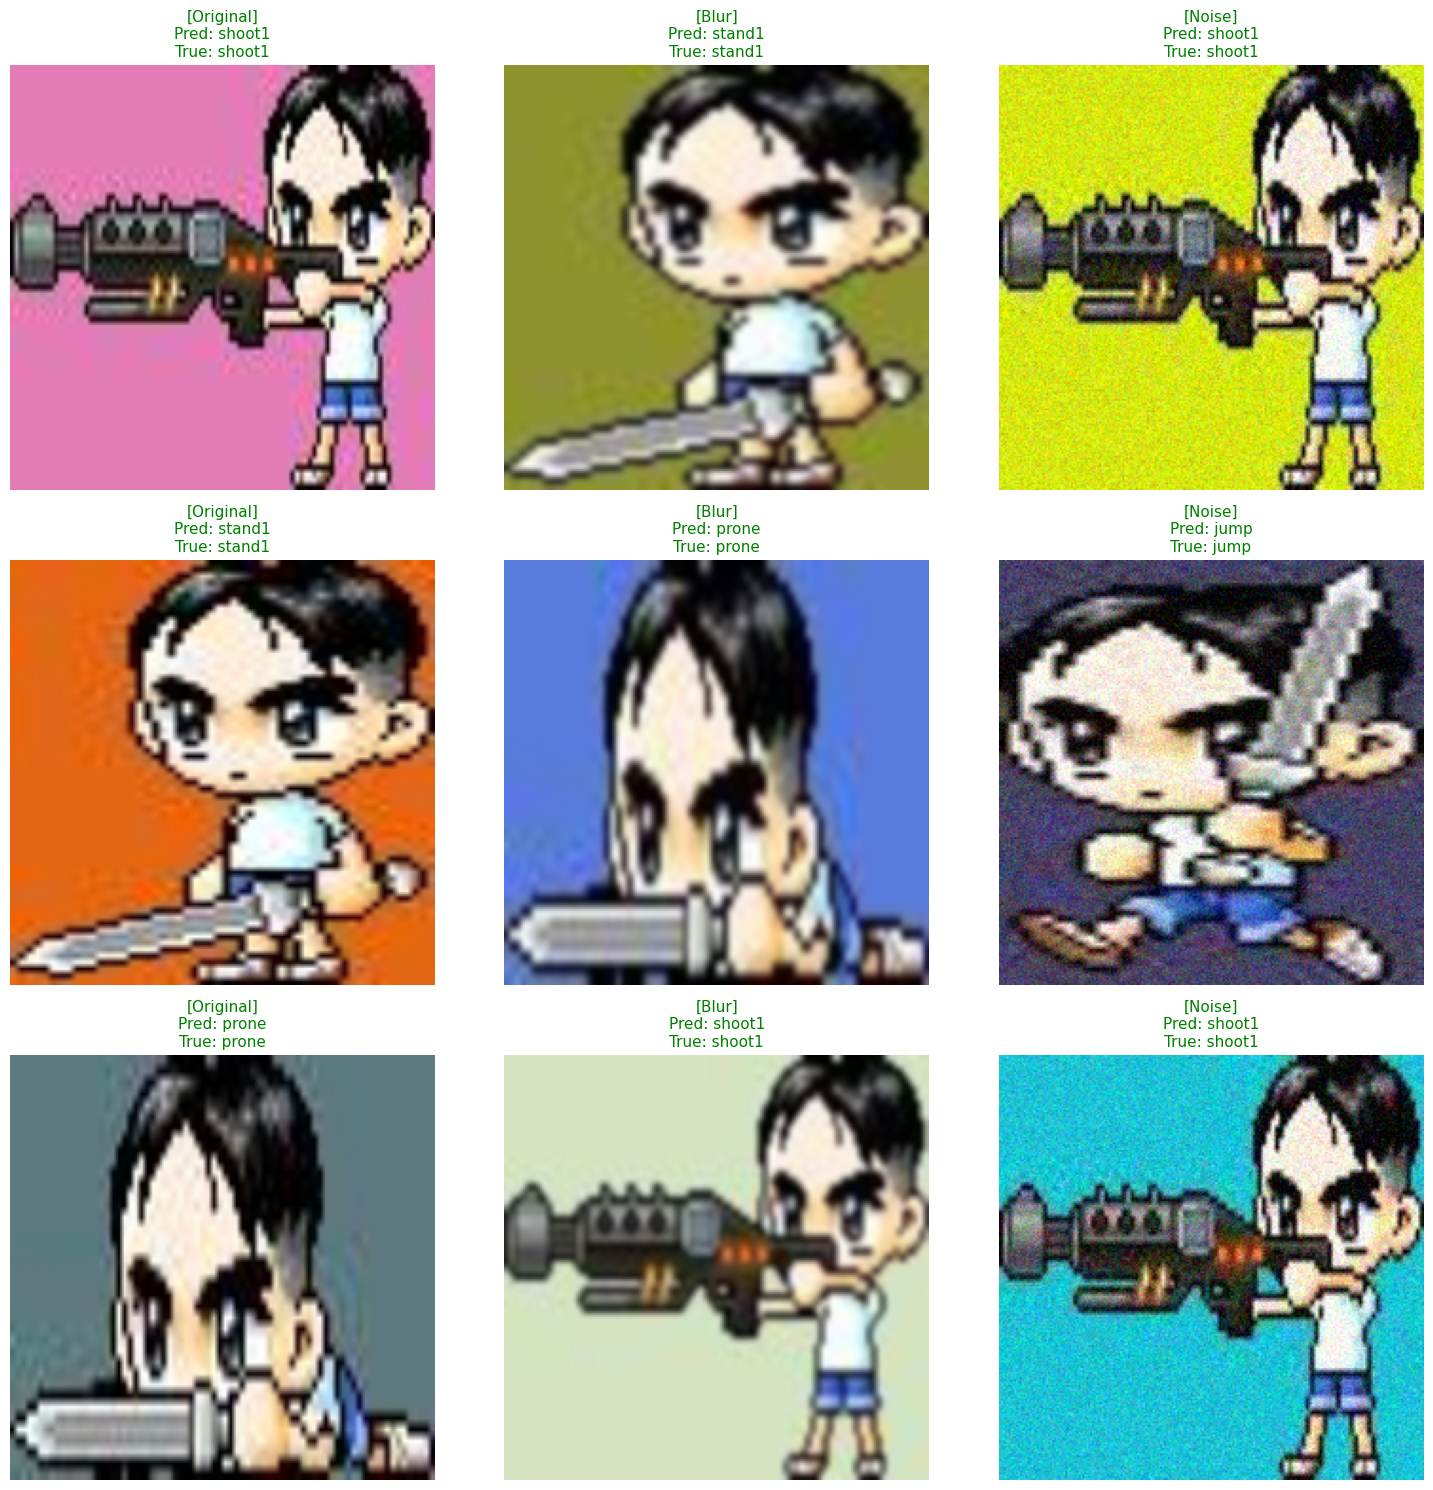

Final Test $Accuracy$: 100.00%


In [25]:
# 1. 학습 곡선 확인
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

# 2. 베스트 모델 로드 (가장 잘 학습된 시점의 가중치 적용)
model.load_state_dict(torch.load("best_pose_classifier.pth"))

# 3. 클래스 리스트 준비
class_names = sorted(train_dataset.classes)

# 4. 혼동 행렬 시각화
print("Generating Confusion Matrix...")
plot_confusion_matrix(model, test_loader, DEVICE, class_names)

# 5. 샘플 이미지 추론 결과 시각화
print("Visualizing Sample Predictions...")
# 예시 호출
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions_varied(model, test_loader, device, class_names, num_images=9)

# 6. 최종 테스트 셋 정확도 출력
evaluate_test_set()

In [26]:
import os
import torch

# 저장 경로 설정 (~/maple-vision-search/weights/)
save_dir = os.path.expanduser("~/maple-vision-search/weights")
save_path = os.path.join(save_dir, "best_pose_classifier.pth")

# 폴더가 없으면 생성
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")

# 현재 메모리에 있는 최적의 모델 가중치 저장
# (이미 'best_pose_classifier.pth'로 저장된 파일을 이동하거나 새로 저장)
torch.save(model.state_dict(), save_path)

print(f"Model weights successfully saved to: {save_path}")

Model weights successfully saved to: /home/ssy/maple-vision-search/weights/best_pose_classifier.pth
